In [1]:

import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt


In [2]:

begin = '1993-02-01'
yf.pdr_override() 
ticker = 'SPY'
df = pdr.get_data_yahoo(ticker, begin)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.301025,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.354620,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.622656,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.729866,531500
1993-02-05,44.968750,45.062500,44.718750,44.968750,25.711985,492100
...,...,...,...,...,...,...
2023-03-27,398.119995,398.920013,395.559998,396.489990,396.489990,74010400
2023-03-28,395.769989,396.489990,393.690002,395.600006,395.600006,62871700
2023-03-29,399.929993,401.600006,398.679993,401.350006,401.350006,77497900


<Axes: xlabel='Date'>

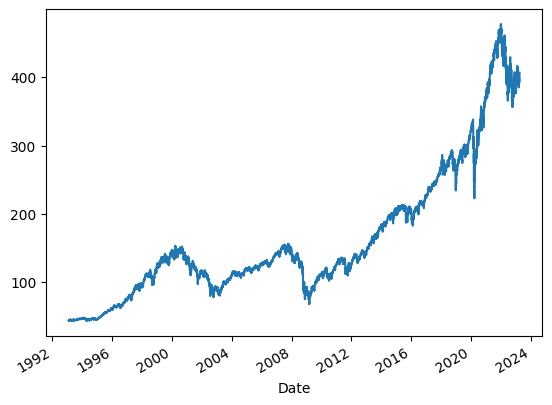

In [3]:
close = df['Close']

close.plot()

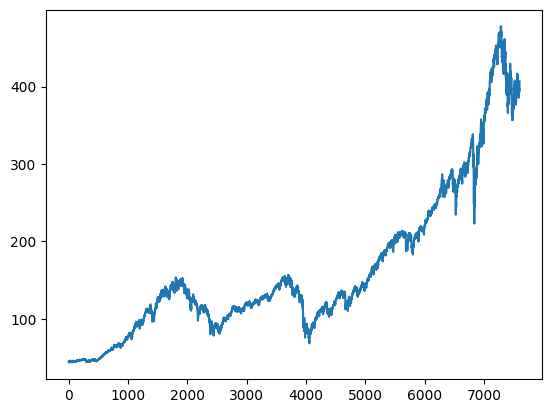

In [4]:
ds = close.values
plt.plot(ds)

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [7]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70) # train set is 70%
test_size = len(ds_scaled) - train_size # test is the other 30%


In [8]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),: 1]

In [9]:
#creating dataset in time series for LSTM model 
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [10]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [11]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

2023-03-31 12:46:05.561463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

2023-03-31 12:46:09.155817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
82/82 [==============================] - 13s 125ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 2/100
82/82 [==============================] - 10s 119ms/step - loss: 7.2202e-05 - val_loss: 0.0030
Epoch 3/100
82/82 [==============================] - 10s 118ms/step - loss: 7.2146e-05 - val_loss: 0.0029
Epoch 4/100
82/82 [==============================] - 10s 118ms/step - loss: 6.7647e-05 - val_loss: 0.0024
Epoch 5/100
82/82 [==============================] - 10s 119ms/step - loss: 6.7734e-05 - val_loss: 0.0019
Epoch 6/100
82/82 [==============================] - 10s 119ms/step - loss: 6.0548e-05 - val_loss: 0.0020
Epoch 7/100
82/82 [==============================] - 10s 119ms/step - loss: 5.9489e-05 - val_loss: 9.3994e-04
Epoch 8/100
82/82 [==============================] - 10s 118ms/step - loss: 5.7986e-05 - val_loss: 0.0012
Epoch 9/100
82/82 [==============================] - 10s 118ms/step - loss: 5.6365e-05 - val_loss: 8.0055e-04
Epoch 10/100
82/82 [======================

82/82 [==============================] - 9s 115ms/step - loss: 1.8789e-05 - val_loss: 2.1378e-04
Epoch 76/100
82/82 [==============================] - 9s 115ms/step - loss: 1.1030e-05 - val_loss: 9.1934e-05
Epoch 77/100
82/82 [==============================] - 9s 115ms/step - loss: 1.0828e-05 - val_loss: 1.0196e-04
Epoch 78/100
82/82 [==============================] - 9s 115ms/step - loss: 1.1513e-05 - val_loss: 8.8473e-05
Epoch 79/100
82/82 [==============================] - 9s 116ms/step - loss: 1.0600e-05 - val_loss: 1.0032e-04
Epoch 80/100
82/82 [==============================] - 9s 115ms/step - loss: 1.1500e-05 - val_loss: 1.1711e-04
Epoch 81/100
82/82 [==============================] - 9s 116ms/step - loss: 1.1788e-05 - val_loss: 1.5211e-04
Epoch 82/100
82/82 [==============================] - 9s 115ms/step - loss: 1.1347e-05 - val_loss: 9.5408e-05
Epoch 83/100
82/82 [==============================] - 9s 116ms/step - loss: 1.3234e-05 - val_loss: 1.0129e-04
Epoch 84/100
82/82 [===

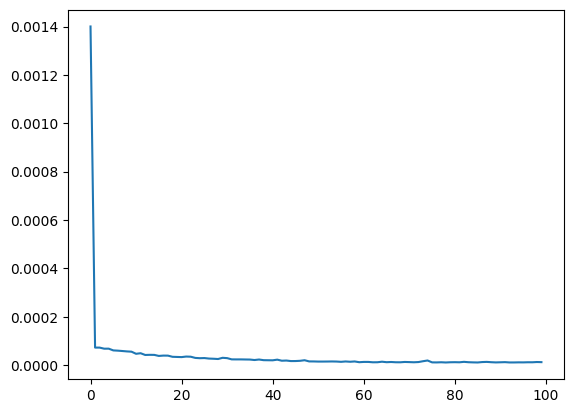

In [15]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss, label='Loss')


In [16]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

69/69 [==============================] - 2s 25ms/step


In [17]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

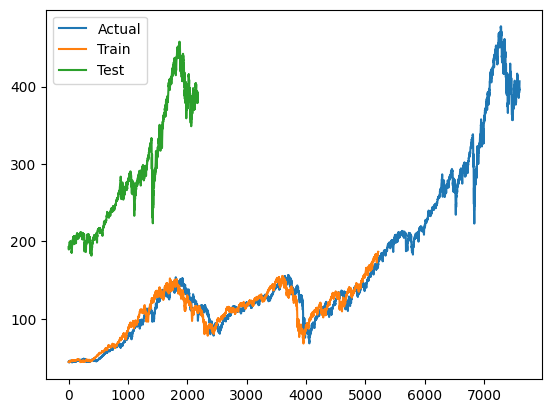

In [18]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled), label="Actual")
plt.plot(train_predict, label="Train")
plt.plot(test_predict, label="Test")
plt.legend()

In [19]:
test = np.vstack((train_predict,test_predict))

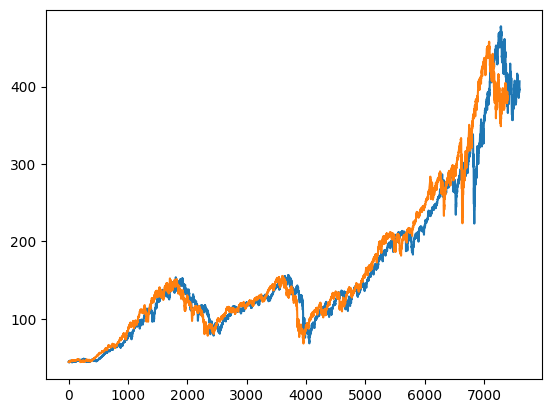

In [20]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test, label='Test')

In [24]:
#Getting the last 100 days records
fut_inp = ds_test[2180:]
print(len(fut_inp))

100


In [25]:
fut_inp = fut_inp.reshape(1,-1)
tmp_inp = list(fut_inp)

#Creating list of the last 728 data
tmp_inp = tmp_inp[0].tolist()

In [26]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
print(lst_output)

print(len(ds_scaled))

[[0.8118422031402588], [0.7850520610809326], [0.7706365585327148], [0.7593124508857727], [0.7492173910140991], [0.7391902208328247], [0.7291849851608276], [0.719390332698822], [0.7099624872207642], [0.7009615898132324], [0.6923818588256836], [0.6841890215873718], [0.6763432621955872], [0.6688081622123718], [0.6615515947341919], [0.6545447707176208], [0.6477620005607605], [0.6411797404289246], [0.6347769498825073], [0.6285343766212463], [0.6224358081817627], [0.6164674162864685], [0.6106165051460266], [0.6048724055290222], [0.5992264151573181], [0.5936707258224487], [0.5881991982460022], [0.582806408405304], [0.577487587928772], [0.572239339351654]]
7597


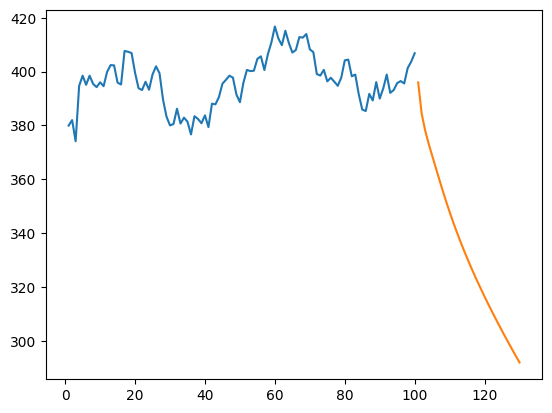

In [29]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[7497:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

7627


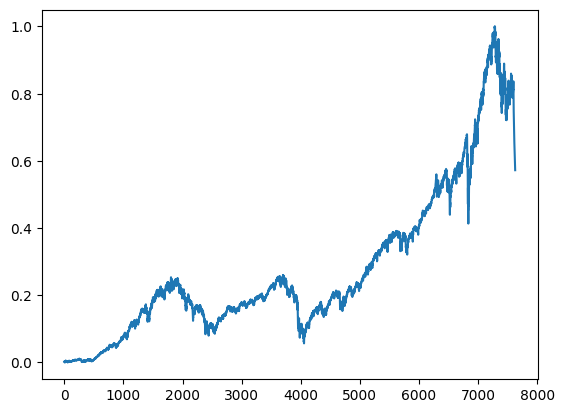

In [30]:
ds_new = ds_scaled.tolist()
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new)
print(len(ds_new))

In [31]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()


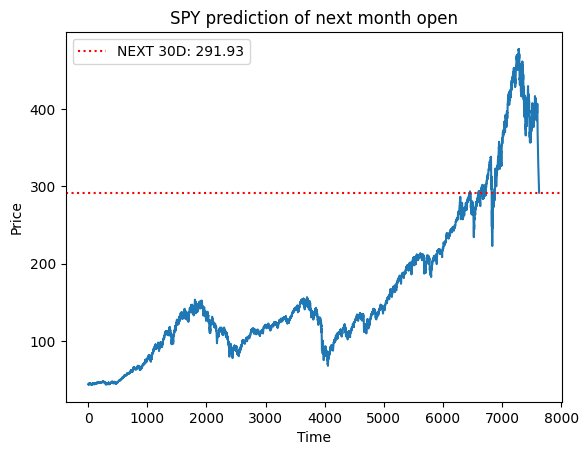

In [32]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(ticker))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()


In [ ]:
ONNXModelPath = "../Users/antoinesfeir/Documents/GitHub/SWMG/QuantU/wwwroot/ml"

from onnx import __version__, IR_VERSION
from onnx.defs import onnx_opset_version
print(f"onnx.__version__={__version__!r}, opset={onnx_opset_version()}, IR_VERSION={IR_VERSION}")

In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt

In [ ]:
num_features = 1
intitial_type = [('feature_input', FloatTensorType([None, num_features]))]
onx = convert_sklearn(model, intitial_types=intitial_type)
with open(ONNXModelPath, "wb") as f:
    f.write(onx.SerializeToString())